# Industrial Applications of Artificial Intelligence - Predictive Maintenance

### This notebook is part of the second hand-in regarding the secondary sector in the lecture Industrial Applications of AI by Niklas Sabel (Matr. no. 1599748)

Industrial companies rely heavily on the machines that operate within their assembly lines. Even the slighest error that would cause the line to be stopped will result in losses of serveral hundred to thousands of euros. In 2015, insiders calculated that one minute of downtime costs Daimler, BMW and AUDI between €1000 and €6000 [(src)](https://www.dvz.de/rubriken/logistik/it-in-der-logistik/detail/news/geruestet-fuer-den-blackout.html#:~:text=Denn%20eine%20Minute%20Bandstillstand%20bei,zwischen%201000%20und%206000%20EUR.). Due to rising competition in a global economy, predictive maintenance becomes a crucial task to no lose money and time in operations, because a company is able to prevent breakdowns with early countermeasures. The challenge arises for the company to prevent components from being replaced too early in the lifecycle and still ensuring reliability. Machine Learning can help in this task. By making use of data from the machines itself and sensors in the surrounding, companies are able to plan ahead and schedule actions to keep their assembly line healthy. One possible way to do this, is modelling the failure/non-failure of a machine as a binary classification. In the following we want to explore how to preprocess a related dataset and how models are able to support companies in recognizing a failure or not.

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.models import Model
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import tensorflow as tf
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape, UpSampling2D

## I. Import Data

The dataset can be found on kaggle unter the following [URL](https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification?select=predictive_maintenance.csv). As real data is in most of the cases a secret that is hidden by the respective company to not give an edge to competitors, we make use of a synthetically generated dataset found on kaggle that reflects real predictive maintenance encountered in industry. The dataset was  [published](https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset ) by the Center for Machine Learning and Intelligent Systems of the University of California . First of all, the dataset consists out of 10.000 entries containing eight features and two targets, which will be described in the following.
* UDI: unique identifier having the same value as the corresponding index
* Product ID: Combination of a letter and a 4-digit serial number. The value of the letter reflects the quality of the product, where L stands for low, M for medium and H for high.
* Type: Again reflects the quality of the product in the same manner as the product ID.
* Air temperature [K]: Refleccts the temperature of the surrounding air measured in Kalvin (0°C = 173,15 K).
* Process temperature [K]: Measures the temperature within the process/machine in Kalvin.
* Rotational speed [rpm]: Corresponds to the rotation speed of the machine measured revolutions per minute .
* Torque [Nm]: Moment of force, rotational force in Newtonmeter. Rotational equivalent to linear force.
* Tool wear [min]: Gradual failure of tools due to regular operation. Depending on quality the add different minutes to the used tool (H/M/L -> 5/3/2 minutes).
* Target: Binary: 1: Failure/0: Non-Failure 
* Failure Type

In [50]:
dir_path ='../../src/data/Abgabe_2/'
df = pd.read_csv(os.path.join(dir_path, "predictive_maintenance.csv"))
df.head(10)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
5,6,M14865,M,298.1,308.6,1425,41.9,11,0,No Failure
6,7,L47186,L,298.1,308.6,1558,42.4,14,0,No Failure
7,8,L47187,L,298.1,308.6,1527,40.2,16,0,No Failure
8,9,M14868,M,298.3,308.7,1667,28.6,18,0,No Failure
9,10,M14869,M,298.5,309.0,1741,28.0,21,0,No Failure


As we already know that UDI is always the same value as the index+1, we discard the column.

In [51]:
df = df.drop(columns=['UDI'])
# look at distribution
df.describe().transpose().applymap("{:.2f}".format)

,count,mean,std,min,25%,50%,75%,max
Air temperature [K],10000.00,300.00,2.00,295.30,298.30,300.10,301.50,304.50
Process temperature [K],10000.00,310.01,1.48,305.70,308.80,310.10,311.10,313.80
Rotational speed [rpm],10000.00,1538.78,179.28,1168.00,1423.00,1503.00,1612.00,2886.00
Torque [Nm],10000.00,39.99,9.97,3.80,33.20,40.10,46.80,76.60
Tool wear [min],10000.00,107.95,63.65,0.00,53.00,108.00,162.00,253.00
Target,10000.00,0.03,0.18,0.00,0.00,0.00,0.00,1.00


In [52]:
df.isna().sum()

Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

Since we have a synthetical dataset, we do not have any NA values. So, we do not need to further preprocess the data in that regard. In the following, we will also discard the failure type, as we want to focus on the binary classification of failure/non-failure. Including the failure type column as a feature to the algorithm would be a false predictor, as it would spoil the label since no-failure does always correspond to 0 in the target.

In [53]:
df = df.drop(columns=['Failure Type'])

After dropping the column, we will again look at our data to decide whether we have to scale it or not.

In [54]:
# look at distribution
df.describe().transpose().applymap("{:.2f}".format)

,count,mean,std,min,25%,50%,75%,max
Air temperature [K],10000.00,300.00,2.00,295.30,298.30,300.10,301.50,304.50
Process temperature [K],10000.00,310.01,1.48,305.70,308.80,310.10,311.10,313.80
Rotational speed [rpm],10000.00,1538.78,179.28,1168.00,1423.00,1503.00,1612.00,2886.00
Torque [Nm],10000.00,39.99,9.97,3.80,33.20,40.10,46.80,76.60
Tool wear [min],10000.00,107.95,63.65,0.00,53.00,108.00,162.00,253.00
Target,10000.00,0.03,0.18,0.00,0.00,0.00,0.00,1.00


We see that our scales for the different features, differ a lot. That could possibly have a big impact on the algorithms' performances. So, we make use of the StandardScaler to make the features comparable.

In [55]:
# define standard scaler
scaler = StandardScaler()
# features to scale
numerical_features = ['Air temperature [K]','Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]']
# transform data
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [56]:
df

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,M14860,M,-0.952389,-0.947360,0.068185,0.282200,-1.695984,0
1,L47181,L,-0.902393,-0.879959,-0.729472,0.633308,-1.648852,0
2,L47182,L,-0.952389,-1.014761,-0.227450,0.944290,-1.617430,0
3,L47183,L,-0.902393,-0.947360,-0.590021,-0.048845,-1.586009,0
4,L47184,L,-0.902393,-0.879959,-0.729472,0.001313,-1.554588,0
...,...,...,...,...,...,...,...,...
9995,M24855,M,-0.602417,-1.082162,0.363820,-1.052012,-1.476034,0
9996,H39410,H,-0.552421,-1.082162,0.520005,-0.821283,-1.428902,0
9997,M24857,M,-0.502425,-0.947360,0.592519,-0.660777,-1.350349,0
9998,H39412,H,-0.502425,-0.879959,-0.729472,0.854005,-1.303217,0


On top of that, we currently have currently have two categorical features. For the algorithms to be able to work with them in the downstream tasks, we will one-hot encode them. However, before we do that, we will get rid of the letter in the product ID, as we always have that in the type column already.

In [63]:
# we strip the letters from the numbers and use only the numbers for the Product ID
df['Product ID'] = df['Product ID'].apply(lambda row: int(''.join(filter(str.isdigit, row))))

In [64]:
df.head(10)

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,14860,M,-0.952389,-0.947360,0.068185,0.282200,-1.695984,0
1,47181,L,-0.902393,-0.879959,-0.729472,0.633308,-1.648852,0
2,47182,L,-0.952389,-1.014761,-0.227450,0.944290,-1.617430,0
3,47183,L,-0.902393,-0.947360,-0.590021,-0.048845,-1.586009,0
4,47184,L,-0.902393,-0.879959,-0.729472,0.001313,-1.554588,0
5,14865,M,-0.952389,-0.947360,-0.634645,0.191915,-1.523166,0
6,47186,L,-0.952389,-0.947360,0.107231,0.242073,-1.476034,0
7,47187,L,-0.952389,-0.947360,-0.065687,0.021376,-1.444613,0
8,14868,M,-0.852397,-0.879959,0.715235,-1.142297,-1.413191,0
9,14869,M,-0.752405,-0.677756,1.128009,-1.202487,-1.366059,0


In [66]:
# we still see that we have no duplicate numbers
df['Product ID'].nunique()

10000

We can still see that we do not have any duplicates in our column. So, the ID does not offer any further information in our downstream tasks. So, we discard this column as it has a 1:1 relationship to our index.

In [67]:
df = df.drop(columns=['Product ID'])

In [68]:
# encode type as last remaining categorical feature
categorical_features = ['Type']
encoder = OneHotEncoder()
#create encoded dataframe
encoded = pd.DataFrame(encoder.fit_transform(df[categorical_features]).toarray(), columns=encoder.get_feature_names(categorical_features))
df_ohe = df.drop(columns=categorical_features).join(encoded)
df_ohe.head(10)

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Type_H,Type_L,Type_M
0,-0.952389,-0.947360,0.068185,0.282200,-1.695984,0,0.0,0.0,1.0
1,-0.902393,-0.879959,-0.729472,0.633308,-1.648852,0,0.0,1.0,0.0
2,-0.952389,-1.014761,-0.227450,0.944290,-1.617430,0,0.0,1.0,0.0
3,-0.902393,-0.947360,-0.590021,-0.048845,-1.586009,0,0.0,1.0,0.0
4,-0.902393,-0.879959,-0.729472,0.001313,-1.554588,0,0.0,1.0,0.0
5,-0.952389,-0.947360,-0.634645,0.191915,-1.523166,0,0.0,0.0,1.0
6,-0.952389,-0.947360,0.107231,0.242073,-1.476034,0,0.0,1.0,0.0
7,-0.952389,-0.947360,-0.065687,0.021376,-1.444613,0,0.0,1.0,0.0
8,-0.852397,-0.879959,0.715235,-1.142297,-1.413191,0,0.0,0.0,1.0
9,-0.752405,-0.677756,1.128009,-1.202487,-1.366059,0,0.0,0.0,1.0


In a last preprocessing step, we will deeper investigate that in the following and drop a feature if it has a correlation of more than 0.8 to one of the other features (excluding the target).

In [69]:
def drop_correlated_features(df, thr=0.8):
    """
    Function to detect all correlated features
    :param df: general dataframe
    :param thr: threshold for the correlation param
    :return: dataframe without correlated features
    """
    correlated_features = set()
    correlation_matrix = df.corr()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > thr:
                print(
                    f"The following features are correlated: {correlation_matrix.columns[i]} and {correlation_matrix.columns[j]}. Correlation = {round(abs(correlation_matrix.iloc[i, j]), 2)}")
                colname = correlation_matrix.columns[j]
                correlated_features.add(colname)
    print(f"Drop the following features: {correlated_features}")
    # drop correlated features
    df = df.drop(columns=correlated_features)

    return df

C:\Users\Nikla\AppData\Local\Temp\ipykernel_10268\3025600473.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


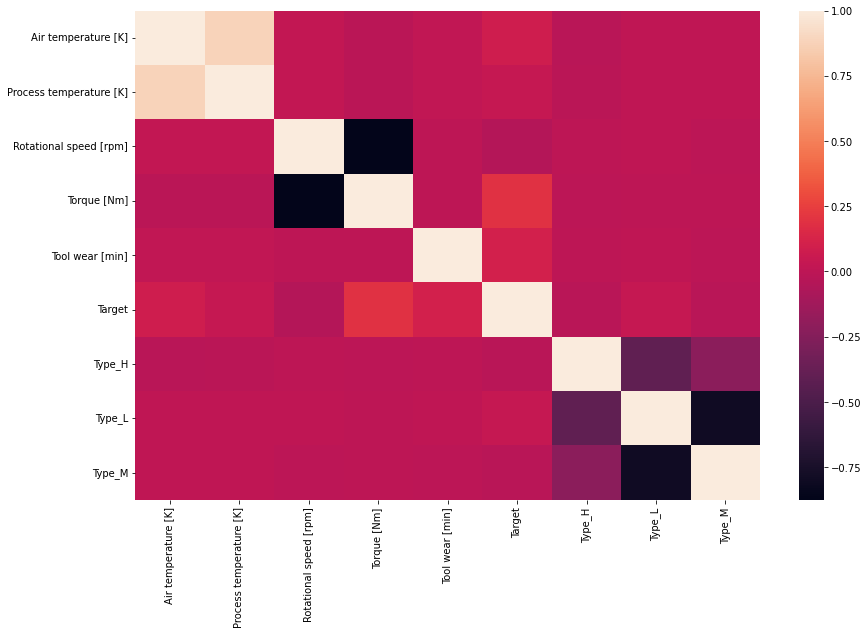

In [71]:
# investigate correlation heatmap
corrMatrix=df_ohe.corr()
f=plt.figure(figsize=(14,9))
sns.heatmap(corrMatrix, annot=False)
f.show()

In [73]:
#drop target to not use it in the correlations of the explanatory variables
df_target = df_ohe['Target']
df_cor = df_ohe.drop(columns=['Target'])
# drop highly correlated features
df_cor = drop_correlated_features(df_cor)

The following features are correlated: Process temperature [K] and Air temperature [K]. Correlation = 0.88
The following features are correlated: Torque [Nm] and Rotational speed [rpm]. Correlation = 0.88
The following features are correlated: Type_M and Type_L. Correlation = 0.8
Drop the following features: {'Air temperature [K]', 'Rotational speed [rpm]', 'Type_L'}


We are now done with preprocessing and will create a train-test split in the following that can be used in downstream tasks.

# II. Train-Test-Split

# III. First baseline

# VI. Discussion

## VII. Outlook